# Test 2: Generate Overstated, Neutral, Understated Resumes

This notebook generates 450 resumes (150 per style) to test if models have bias towards:
- Giving "senior" to overstated resumes (even when true level is junior)
- Giving "junior" to understated resumes (even when true level is senior)

**Generation Flow:**
- For each seniority (junior, mid, senior): 50 resumes
- For each resume: generate neutral → then overstated + understated versions
- Total: 50 × 3 seniorities × 3 styles = 450 resumes

In [43]:
# Setup
import os
import json
import urllib.request
import pandas as pd
import numpy as np
import time
import unicodedata

# OpenRouter Config - Auto-switch from free to paid on rate limit
MODEL_FREE = "google/gemma-3n-e4b-it:free"
MODEL_PAID = "google/gemma-3n-e4b-it"
CURRENT_MODEL = MODEL_FREE
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

if not OPENROUTER_API_KEY:
    raise ValueError("Set OPENROUTER_API_KEY environment variable")

## API Call Function

In [44]:
def call_openrouter(prompt, max_retries=2):
    """Call OpenRouter API with retry logic and auto-switch to paid model."""
    global CURRENT_MODEL
    
    for attempt in range(max_retries):
        payload = json.dumps({
            "model": CURRENT_MODEL,
            "messages": [{"role": "user", "content": prompt}],
        }).encode("utf-8")
        
        req = urllib.request.Request(
            OPENROUTER_URL,
            data=payload,
            headers={
                "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                "Content-Type": "application/json"
            }
        )
        
        try:
            with urllib.request.urlopen(req, timeout=120) as resp:
                result = json.loads(resp.read().decode("utf-8"))
                text = result["choices"][0]["message"]["content"].strip()
                
                # Normalize Unicode (fancy hyphens, quotes, etc.)
                text = unicodedata.normalize("NFKC", text)
                
                # Additional cleanup: encode and re-decode to fix double-encoding
                try:
                    text = text.encode('latin-1').decode('utf-8')
                except (UnicodeEncodeError, UnicodeDecodeError):
                    pass  # If it fails, text is already clean
                
                return text
                
        except urllib.error.HTTPError as e:
            error_body = e.read().decode('utf-8')
            print(f"Attempt {attempt+1} failed: {e} - {error_body}")
            
            # Check if rate limited on free model
            if "rate" in error_body.lower() and CURRENT_MODEL == MODEL_FREE:
                print(f"⚠️  Rate limit hit on free model. Switching to paid: {MODEL_PAID}")
                CURRENT_MODEL = MODEL_PAID
                continue  # Retry immediately with paid model
            
            if attempt < max_retries - 1:
                time.sleep(2)
                
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(2)
    
    return None

## Prompt Templates

In [45]:
NEUTRAL_PROMPT = """Generate a complete, realistic resume for a {seniority}-level professional in [FIELD/ROLE].

Create a full resume document in plain text format with these sections:
- Full name (generate a realistic name)
- Contact information (email, phone, location - use realistic formats)
- Professional summary (write as the candidate in first person)
- Work experience (2-4 positions with company names, locations, dates, and detailed responsibilities)
- Education (degree, institution, graduation year)
- Technical skills (list relevant skills)
- Optional: Certifications, Projects, or other relevant sections

Guidelines:
- Use realistic company names, dates (appropriate to career level), and locations
- Write responsibilities and achievements in past tense, factual tone
- Include specific technologies, tools, and methodologies
- Make employment dates and career progression logical
- Use plain text only - no asterisks, no bold, no headers with symbols, no markdown
- Let the content determine length naturally
- Do NOT use the words "junior", "mid-level", "senior", or "entry-level" anywhere

Output the complete resume in plain text format only."""

OVERSTATED_PROMPT = """Rewrite this resume in an OVERSTATED, self-promotional style.

ORIGINAL RESUME:
{neutral_resume}

Transform this into an overstated version:
- Amplify every achievement and responsibility
- Use powerful, dramatic action verbs (spearheaded, revolutionized, orchestrated, pioneered, architected)
- Add impressive-sounding metrics and scale indicators ("enterprise-level", "mission-critical", "across X teams")
- Make contributions sound more impactful and strategic
- Turn routine tasks into major initiatives
- Elevate job titles slightly if possible without changing them completely
- Add buzzwords and industry jargon
- Keep the same structure and sections but inflate the language throughout

Maintain plain text format - no asterisks, bold, markdown, or decorations.
Do NOT use the words "junior", "mid-level", "senior", or "entry-level".

Output the complete overstated resume in plain text format only."""

UNDERSTATED_PROMPT = """Rewrite this resume in an UNDERSTATED, modest style.

ORIGINAL RESUME:
{neutral_resume}

Transform this into an understated version:
- Downplay all achievements and contributions
- Use passive, humble language (assisted, contributed to, helped with, supported, participated in)
- Remove or minimize metrics, numbers, and impact statements
- Make accomplishments sound routine or collaborative rather than individual
- Add qualifying phrases (e.g., "helped to", "worked as part of a team to")
- Turn leadership into support roles
- Remove strong action verbs and replace with softer alternatives
- Make the scope of work sound smaller or less significant
- Keep the same structure and sections but deflate the language throughout

Maintain plain text format - no asterisks, bold, markdown, or decorations.
Do NOT use the words "junior", "mid-level", "senior", or "entry-level".

Output the complete understated resume in plain text format only."""

## Generate Resumes

Generate 50 resumes per seniority level, each with neutral/overstated/understated versions.

In [46]:
# Generation settings
SENIORITIES = ["junior", "mid", "senior"]
RESUMES_PER_SENIORITY = 40

# Storage
results = []

for seniority in SENIORITIES:
    print(f"\n{'-'*50}")
    print(f"Generating {RESUMES_PER_SENIORITY} {seniority.upper()} resumes...")
    print(f"{'-'*50}")
    
    for i in range(RESUMES_PER_SENIORITY):
        print(f"  [{i+1}/{RESUMES_PER_SENIORITY}] ", end="", flush=True)
        
        # Step 1: Generate neutral resume
        neutral = call_openrouter(NEUTRAL_PROMPT.format(seniority=seniority))
        if not neutral:
            print("FAILED (neutral)")
            continue
        print("neutral ✓ ", end="", flush=True)
        
        # Step 2: Generate overstated from neutral
        overstated = call_openrouter(OVERSTATED_PROMPT.format(neutral_resume=neutral))
        if not overstated:
            print("FAILED (overstated)")
            continue
        print("overstated ✓ ", end="", flush=True)
        
        # Step 3: Generate understated from neutral
        understated = call_openrouter(UNDERSTATED_PROMPT.format(neutral_resume=neutral))
        if not understated:
            print("FAILED (understated)")
            continue
        print("understated ✓")
        
        # Store results
        results.append({
            "neutral": neutral,
            "overstated": overstated,
            "understated": understated,
            "seniority": seniority
        })
        
        time.sleep(0.2)

print(f"\n\nGeneration complete. Total: {len(results)} resume sets")


--------------------------------------------------
Generating 40 JUNIOR resumes...
--------------------------------------------------
  [1/40] neutral ✓ overstated ✓ understated ✓
  [2/40] neutral ✓ overstated ✓ understated ✓
  [3/40] neutral ✓ overstated ✓ understated ✓
  [4/40] neutral ✓ overstated ✓ understated ✓
  [5/40] neutral ✓ overstated ✓ understated ✓
  [6/40] neutral ✓ overstated ✓ understated ✓
  [7/40] neutral ✓ overstated ✓ understated ✓
  [8/40] neutral ✓ overstated ✓ understated ✓
  [9/40] neutral ✓ overstated ✓ understated ✓
  [10/40] neutral ✓ overstated ✓ understated ✓
  [11/40] neutral ✓ overstated ✓ understated ✓
  [12/40] neutral ✓ overstated ✓ understated ✓
  [13/40] neutral ✓ overstated ✓ understated ✓
  [14/40] neutral ✓ overstated ✓ understated ✓
  [15/40] neutral ✓ overstated ✓ understated ✓
  [16/40] neutral ✓ overstated ✓ understated ✓
  [17/40] neutral ✓ overstated ✓ understated ✓
  [18/40] neutral ✓ overstated ✓ understated ✓
  [19/40] neutral ✓ overstat

## Save to CSV

In [47]:
# Save to CSV
df = pd.DataFrame(results)
df.to_csv("test2_resumes.csv", index=False, encoding='utf-8')

print(df['seniority'].value_counts())

seniority
junior    40
mid       40
senior    40
Name: count, dtype: int64


---
## Metrics: Validate Generated Resumes

Check that neutral, overstated, and understated versions are similar (same content, different style).

### Metric 1: Word Count Comparison

In [48]:
# Word count for each style
neutral_wc = [len(str(r).split()) for r in df['neutral']]
overstated_wc = [len(str(r).split()) for r in df['overstated']]
understated_wc = [len(str(r).split()) for r in df['understated']]

print("WORD COUNT BY STYLE")
print(f"{'Style':<15} {'Average':<12} {'Min':<10} {'Max':<10}")
print("-" * 50)
print(f"{'Neutral':<15} {np.mean(neutral_wc):.0f}{'':<7} {np.min(neutral_wc):<10} {np.max(neutral_wc):<10}")
print(f"{'Overstated':<15} {np.mean(overstated_wc):.0f}{'':<7} {np.min(overstated_wc):<10} {np.max(overstated_wc):<10}")
print(f"{'Understated':<15} {np.mean(understated_wc):.0f}{'':<7} {np.min(understated_wc):<10} {np.max(understated_wc):<10}")

WORD COUNT BY STYLE
Style           Average      Min        Max       
--------------------------------------------------
Neutral         435        294        582       
Overstated      588        370        763       
Understated     324        208        432       


### Metric 2: Content Similarity Between Styles (TF-IDF Cosine)

High similarity = same content, just different wording style. Meaning that Scores > 0.5 indicate the versions maintain similar content

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

# Calculate similarity between neutral-overstated and neutral-understated
neutral_overstated_sims = []
neutral_understated_sims = []

for idx, row in df.iterrows():
    # Neutral vs Overstated
    mat = tfidf.fit_transform([str(row['neutral']), str(row['overstated'])])
    neutral_overstated_sims.append(cosine_similarity(mat[0:1], mat[1:2])[0][0])
    
    # Neutral vs Understated
    mat = tfidf.fit_transform([str(row['neutral']), str(row['understated'])])
    neutral_understated_sims.append(cosine_similarity(mat[0:1], mat[1:2])[0][0])

print("CONTENT SIMILARITY (should be high if same content)")
print(f"Neutral ↔ Overstated:   {np.mean(neutral_overstated_sims):.3f}")
print(f"Neutral ↔ Understated:  {np.mean(neutral_understated_sims):.3f}")

CONTENT SIMILARITY (should be high if same content)
Neutral ↔ Overstated:   0.765
Neutral ↔ Understated:  0.841


### Visualization

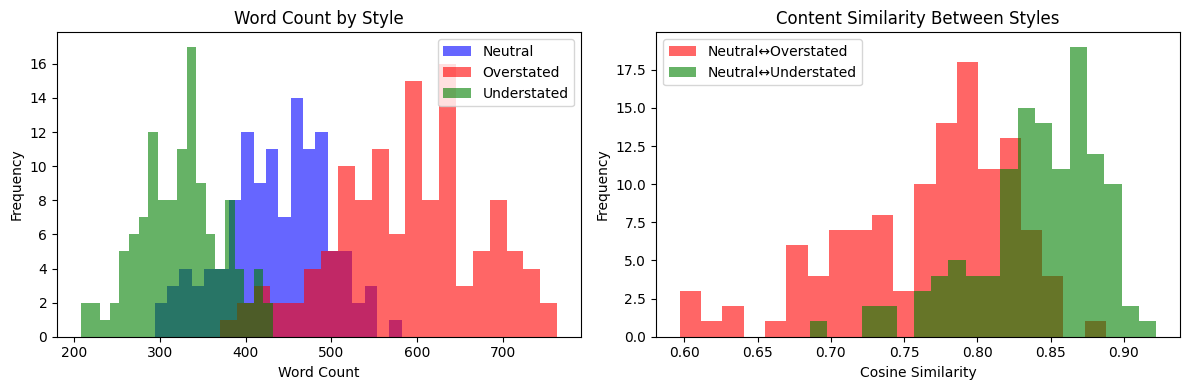

In [50]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Word Count Distribution
axes[0].hist(neutral_wc, bins=20, alpha=0.6, label='Neutral', color='blue')
axes[0].hist(overstated_wc, bins=20, alpha=0.6, label='Overstated', color='red')
axes[0].hist(understated_wc, bins=20, alpha=0.6, label='Understated', color='green')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count by Style')
axes[0].legend()

# Similarity Distribution
axes[1].hist(neutral_overstated_sims, bins=20, alpha=0.6, label='Neutral↔Overstated', color='red')
axes[1].hist(neutral_understated_sims, bins=20, alpha=0.6, label='Neutral↔Understated', color='green')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Content Similarity Between Styles')
axes[1].legend()

plt.tight_layout()
plt.show()